In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ananysharma7113","key":"5b423afd1ca13c1def9759e11db03621"}'}

In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [5]:
!kaggle datasets download catherinehorng/dogbreedidfromcomp

Dataset URL: https://www.kaggle.com/datasets/catherinehorng/dogbreedidfromcomp
License(s): unknown
 99% 687M/691M [00:08<00:00, 185MB/s]
100% 691M/691M [00:08<00:00, 87.7MB/s]


In [6]:
!unzip dogbreedidfromcomp.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

In [ ]:
!rm dogbreedidfromcomp.zip

In [ ]:
!rm sample_submission.csv

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D
from keras.optimizers import Adam


In [9]:
labels_all=pd.read_csv('labels.csv')
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
breeds_all=labels_all['breed']
breed_counts=breeds_all.value_counts()
breed_counts.head()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: count, dtype: int64

In [11]:
#due to computation power limitation
CLASS_NAMES = ['scottish_deerhound','maltese_dog','bernese_mountain_dog']
labels=labels_all[labels_all['breed'].isin(CLASS_NAMES)]
labels=labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


In [12]:
#Assigning X and Y
X_data = np.zeros((len(labels),224,224,3),dtype='float32')
#One Hot Encoding
Y_data = label_binarize(labels['breed'],classes=CLASS_NAMES)

#Converting images to arrays
for i in tqdm(range(len(labels))):
  img=image.load_img('train/%s.jpg' % labels['id'][i],target_size=(224,224))
  img=image.img_to_array(img)
  x=np.expand_dims(img.copy(),axis=0)
  X_data[i]=x/255.0

print(X_data.shape)
print(Y_data.shape)
print(X_data.size)
print(Y_data.size)

100%|██████████| 357/357 [00:01<00:00, 307.74it/s]

(357, 224, 224, 3)
(357, 3)
53738496
1071


In [27]:
#Building Model
model=Sequential()

model.add(Conv2D(filters=64,kernel_size=(5,5),activation='relu',input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=16,kernel_size=(7,7),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=8,kernel_size=(5,5),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(len(CLASS_NAMES),activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer=Adam(0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 110, 110, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 54, 54, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 24, 24, 16)       

In [28]:
#splitting data into train,test and validation datasets
X_train_and_val,X_test,Y_train_and_val,Y_test=train_test_split(X_data,Y_data,test_size=0.1)
X_train,X_val,Y_train,Y_val=train_test_split(X_data,Y_data,test_size=0.2)

In [29]:
print(type(X_train))
print(type(X_val))
print(type(Y_train))
print(type(Y_val))
print(model)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
epochs=100
batch_size=128
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val))

In [33]:
%cd ..

/content


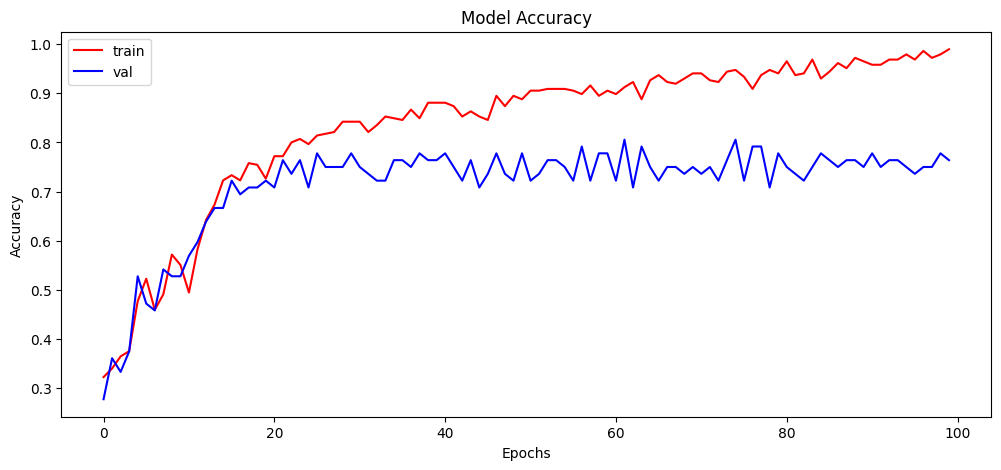

In [36]:
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'],color='r')
plt.plot(history.history['val_accuracy'],color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','val'])
plt.show()

In [37]:
Y_pred=model.predict(X_test)
score=model.evaluate(X_test,Y_test)

print('Accuracy over the test set: \n',round((score[1]*100),2),'%')

2/2 [==============================] - 2s 208ms/step - loss: 0.1451 - accuracy: 0.9722
Accuracy over the test set: 
 97.22 %


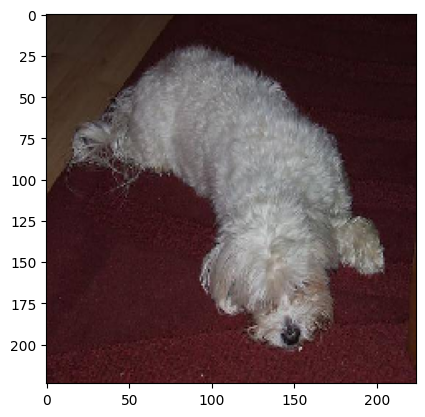

Orignally:  maltese_dog
Predicted:  maltese_dog


In [38]:
plt.imshow(X_test[1,:,:,:])
plt.show()

print('Orignally: ',labels['breed'][np.argmax(Y_test[1])])
print('Predicted: ',labels['breed'][np.argmax(Y_pred[1])])

In [34]:
model.save('dog_breed.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
